# The demonstration of the tropical precipitation module in detailes

# Structure


 1. [Load of](#1-load-of-packages-modules-and-data)

    1.1. [packages](#11-loading-the-necessary-packages)

    1.2. [modules and](#12-loading-the-written-modules)

    1.3. [data with the use of aqua package](#13-loading-the-data-with-the-use-of-aqua-package)

2. [Initialization of precipitation diagnostic and setting the class attributes](#2-initializing-the-class-object-and-setting-the-class-attributes)

3. [Illustration of some preprocessing possibilities of precipitation diagnostic, such as](#3-illustation-of-some-preprocessing-possibilietes-of-precipitation-diagnostic)

    3.1. [Selecting the time range](#31-selecting-the-time-range)

    3.2. [Selection of tropical latitudes](#32-selection-of-tropical-latitudes)

    3.3. [Automatic preprocessing of data](#33-preprocessing)

4. [Calculation of histogram of precipitation/tropical precipitation](#4-calculation-of-histogram-of-precipitationtropicalprecipitation)

    4.1. [with manual data preprocessing](#41-diagnostic-with-manual-data-preprocessing)

    4.2 [automatic data preprocessing](#42-diagnostic-with-automatic-data-preprocessing)

    4.3. [with non uniform binning](#43-histogram-with-not-uniform-binning)
    
5. [Calculation time expectation for a total dataset](#5-expected-calculation-time-for-entire-dataset)
 
6. [Creation of graphics with a graphic module](#6-creation-of-graphics)

    6.1. [Creation of images](#61-images)
    
    6.2. [Creation of animation](#62-animation)

    6.3  [Creation of images of high and low resolution](#63-images-with-the-regrided-the-coordinates)

[Go to the end of file](#the-end)

#

## 1. Load of  packages, modules and data

### 1.1. Loading the necessary packages

In [1]:
#import dask
import re
import os
import importlib
import timeit
import sys
import numpy as np
import xarray

#### Storing the absolute path of the current repository into the variable

In [2]:
with os.popen("pwd ") as f:
    _pwd = f.readline()

pwd = re.split(r'[\n]', _pwd)[0]

#### Setting the path to the diagnostic repository 

In [3]:
sys.path.append(str(pwd)+'/../')

import src.tr_pr_module
import src.time_functions
import src.graphic_creator
import src.slurm_job

### 1.2. Loading the written modules

#### Loading the tropical precipitation module

In [4]:
importlib.reload(src.tr_pr_module)
from  src.tr_pr_module import  xarray_attribute_update, data_size, TR_PR_Diagnostic

#### Loading the time-related functions, which can be used in any diagnostic

In [5]:
importlib.reload(src.time_functions)
from  src.time_functions import time_interpreter, estimated_total_calc_time, optimal_amount_of_timesteps, time_regrider

#### Loading the pakcage which create the animation and images

In [7]:
importlib.reload(src.graphic_creator)
from src.graphic_creator import  animation_creator, image_creator, lon_lat_regrider

#### Activating the slurm job if it is necessary 

In [8]:
importlib.reload(src.slurm_job)
from  src.slurm_job import  slurm_interactive_job, squeue_user, scancel

In [ ]:
slurm_interactive_job()

In [10]:
squeue_user()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4779253   compute dask-wor  b382267 PD       0:00      1 (None)


0

#### Importing the aqua module

In [11]:
import aqua

In [12]:
from aqua import Reader
from aqua.reader import catalogue

In [13]:
configdir = '../../../config/'
diagname  = 'tr_pr'
machine   = 'levante'
catalogue(configdir=configdir)

levante:
  args:
    path: ../../../config//levante/catalog.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


### 1.3. Loading the data with the use of aqua package

#### MSWEP data

In [14]:
reader = Reader(model="MSWEP", exp="past", source="monthly",configdir=configdir)
MSWEP = reader.retrieve()

In [15]:
MSWEP

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1800, time: 502)
Coordinates:
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
  * lat      (lat) float32 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * time     (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01
Data variables:
    tprate   (time, lat, lon) float32 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes:
    history:  Created on 2021-02-04 03:412023-04-17 18:47:10 retrieved by AQU...

#### Regriding the small part/chunk of dataset for tests

In [15]:
MSWEP_chunk = MSWEP["tprate"][10:30,:]

In [16]:
MSWEP_chunk = MSWEP_chunk.compute()

In [20]:
MSWEP_chunk 

<xarray.DataArray 'tprate' (time: 20, lat: 90, lon: 180)>
dask.array<reshape, shape=(20, 90, 180), dtype=float64, chunksize=(6, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T05:00:00 ... 2020-01-20T14:30:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes: (12/16)
    cell_methods:                 t: mean
    long_name:                    Mean total precipitation rate
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        m s**-1
    ...                           ...
    target_units:                 m s**-1
    factor:                       0.001
    offset:                       0
    src_units:                    kg m-2 s-1
    units_fixed:                  1
    regridded:                    1

## 2. Initializing the class object and setting the class attributes

In [17]:
diag = TR_PR_Diagnostic()

diag.num_of_bins    = 15
diag.first_edge     = 0
diag.width_of_bin   = 1*10**(-4)/diag.num_of_bins
diag.bins           = None


diag.trop_lat = 10

# time related attributes 
diag.s_time     = None
diag.f_time     = None
diag.s_timeindex= None
diag.f_timeindex= None
diag.s_year     = None
diag.f_year     = None 
diag.s_month    = None
diag.f_month    = None 

#### User can put specify all attributes during initialization of class object 

In [18]:
diag = TR_PR_Diagnostic(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15)

#### Attributes of the class can be updated in two ways

In [81]:
print(diag.num_of_bins)
diag.num_of_bins = 30
print(diag.num_of_bins)

15
30


#### OR

In [82]:
print(diag.num_of_bins)
diag.class_attributes_update(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/20)
print(diag.num_of_bins)

30
20


## 3. Illustration of some preprocessing possibilities of precipitation diagnostic

#### Timestep of dataset is

In [21]:
time_interpreter(MSWEP)

'M'

In [22]:
time_interpreter(MSWEP_chunk) 

'M'

#### We may want to pass the attributes of entire dataset into our regrided chunk of data. (Also, sum the `history` of datasets) 

In [24]:
MSWEP_chunk = xarray_attribute_update(MSWEP_chunk, MSWEP)

#### Units of precepitation rate

In [17]:
MSWEP_chunk.attrs['units']

'm s**-1'

### 3.2 Selection of tropical latitudes

In [19]:
MSWEP_chunk = MSWEP_chunk.compute()
MSWEP_chunk_trop = diag.ds_per_lat_range(MSWEP_chunk)

In [ ]:
MSWEP_chunk_trop

#### We can modify the selected tropical area as 

In [ ]:
diag.trop_lat = 25

MSWEP_chunk_trop = diag.ds_per_lat_range(MSWEP_chunk)

#### OR 

In [24]:
MSWEP_chunk_trop = diag.ds_per_lat_range(MSWEP_chunk, trop_lat = 10)

## 4. Calculation of histogram of precipitation/tropicalprecipitation


### 4.1. Diagnostic with manual data preprocessing

### Fastest histogram

In [23]:
hist_MSWEP  = diag.hist1d_fast(MSWEP_chunk,  preprocess = False)
hist_MSWEP

<xarray.DataArray (bin: 20)>
array([1.17799395e+08, 9.58757300e+06, 1.82492100e+06, 3.20879000e+05,
       4.91590000e+04, 1.14840000e+04, 3.69700000e+03, 1.40500000e+03,
       6.76000000e+02, 3.12000000e+02, 2.12000000e+02, 1.22000000e+02,
       7.10000000e+01, 3.00000000e+01, 2.50000000e+01, 1.50000000e+01,
       5.00000000e+00, 4.00000000e+00, 4.00000000e+00, 2.00000000e+00])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
Attributes:
    units:         m s**-1
    history:       2023-04-17 18:47:10 variable renamed by AQUA fixer;\n2023-...
    paramId:       172228
    long_name:     Mean total precipitation rate
    cfVarName:     tprate
    shortName:     tprate
    target_units:  m s**-1
    factor:        3.802570537683474e-10
    offset:        0
    src_units:     mm month-1
    units_fixed:   1

#### Only for tropical area

In [24]:
hist_MSWEP_trop  = diag.hist1d_fast(MSWEP_chunk_trop,  preprocess = False)
hist_MSWEP_trop

<xarray.DataArray (bin: 20)>
array([8.931524e+06, 4.121633e+06, 1.124650e+06, 1.907600e+05,
       2.429600e+04, 4.938000e+03, 1.352000e+03, 4.340000e+02,
       1.890000e+02, 6.700000e+01, 5.600000e+01, 2.500000e+01,
       1.700000e+01, 8.000000e+00, 1.400000e+01, 1.300000e+01,
       5.000000e+00, 4.000000e+00, 4.000000e+00, 2.000000e+00])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 1.2e-06 1.267e-06
Attributes:
    units:         m s**-1
    history:       2023-04-17 18:47:10 variable renamed by AQUA fixer;\n2023-...
    paramId:       172228
    long_name:     Mean total precipitation rate
    cfVarName:     tprate
    shortName:     tprate
    target_units:  m s**-1
    factor:        3.802570537683474e-10
    offset:        0
    src_units:     mm month-1
    units_fixed:   1

## 4.2. Diagnostic with automatic data preprocessing

In [50]:
diag = TR_PR_Diagnostic()

# mandatory attributes
diag.num_of_bins = 15
diag.first_edge = 0
diag.width_of_bin = 1*10**(-4)/diag.num_of_bins

# other attributes of class whoch have a default value
diag.trop_lat = 10
diag.s_timeindex = 10
diag.f_timeindex = 20

#### OR

In [18]:
diag = TR_PR_Diagnostic(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/15, s_timeindex = 10, f_timeindex = 20)

In [ ]:
MSWEP

In [20]:
## Add reader as option??

In [21]:
#hist_MSWEP_prepr  = diag.hist1d_fast(MSWEP, reader=reader, trop_lat = 10, s_timeindex = 10,  f_timeindex = 15)
#hist_MSWEP_prepr 

In [ ]:
#hist_MSWEP_prepr  = diag.hist1d_fast(MSWEP, reader=reader, trop_lat = 10,  s_time = '2020:01', f_time ='2020/03/20/12')
#hist_MSWEP_prepr 

In [ ]:
#hist_MSWEP_prepr  = diag.hist1d_fast(MSWEP, reader=reader, trop_lat = 10, s_time = '2020', f_time ='2020.03.20')
#hist_MSWEP_prepr 

### 4.3. Histogram with not uniform binning

In [25]:
bins = np.logspace(-9, -6, 15)
bins

array([1.00000000e-09, 1.63789371e-09, 2.68269580e-09, 4.39397056e-09,
       7.19685673e-09, 1.17876863e-08, 1.93069773e-08, 3.16227766e-08,
       5.17947468e-08, 8.48342898e-08, 1.38949549e-07, 2.27584593e-07,
       3.72759372e-07, 6.10540230e-07, 1.00000000e-06])

In [26]:
diag = TR_PR_Diagnostic(bins = bins, s_timeindex = 10, f_timeindex = 80)

In [27]:
MSWEP_chunk_trop=MSWEP_chunk_trop.compute()

In [28]:
hist_MSWEP_trop_logspaced  = diag.hist1d_np(MSWEP_chunk_trop, preprocess=False, bins=bins)
hist_MSWEP_trop_logspaced

<xarray.DataArray (bin: 14)>
array([ 197844,  386611,  592198,  806705,  962871, 1051409, 1230106,
       1853388, 2939425, 2744776, 1078054,   91722,    3407,     170])
Coordinates:
  * bin      (bin) float64 1e-09 1.638e-09 2.683e-09 ... 3.728e-07 6.105e-07
Attributes:
    units:         m s**-1
    history:       2023-04-17 18:47:10 variable renamed by AQUA fixer;\n2023-...
    paramId:       172228
    long_name:     Mean total precipitation rate
    cfVarName:     tprate
    shortName:     tprate
    target_units:  m s**-1
    factor:        3.802570537683474e-10
    offset:        0
    src_units:     mm month-1
    units_fixed:   1

In [29]:
hist_MSWEP_trop_logspaced   = diag.hist1d_fast(MSWEP_chunk_trop,  preprocess = False, bins=bins)
hist_MSWEP_trop_logspaced 

<xarray.DataArray (bin: 15)>
array([8.555831e+06, 4.063901e+06, 1.102027e+06, 1.861610e+05,
       2.376100e+04, 4.861000e+03, 1.341000e+03, 4.280000e+02,
       1.880000e+02, 6.700000e+01, 5.600000e+01, 2.500000e+01,
       1.700000e+01, 8.000000e+00, 1.400000e+01])
Coordinates:
  * bin      (bin) float64 1e-09 1.638e-09 2.683e-09 ... 6.105e-07 1e-06
Attributes:
    units:         m s**-1
    history:       2023-04-17 18:47:10 variable renamed by AQUA fixer;\n2023-...
    paramId:       172228
    long_name:     Mean total precipitation rate
    cfVarName:     tprate
    shortName:     tprate
    target_units:  m s**-1
    factor:        3.802570537683474e-10
    offset:        0
    src_units:     mm month-1
    units_fixed:   1

## 5. Expected calculation time for entire dataset

####  Checking the calculation time of a small chunk of the dataset

In [25]:
result = %timeit -r 2 -n 1 -o  diag.hist1d_fast(MSWEP_chunk_trop,  preprocess = False)
time_fast_reg, time_fast_reg_stdev =  result.average, result.stdev 

51.4 ms ± 1.71 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


#### Estemated calculation time of entire dataset

In [26]:
estimated_total_calc_time(ds_part = MSWEP_chunk_trop, calc_time = time_fast_reg, ds_full = MSWEP,  units='D')

(11.608603721112013, 0.00013435883936472237)

#### Optimal amount of timesteps

In [27]:
optimal_amount_of_timesteps(ds_part = MSWEP_chunk_trop, calc_time = time_fast_reg,  ds_full = MSWEP, wanted_time ='3H')

(930.3444461936931, 467032)

#

## 6. Creation of graphics 

### 6.1. Images

#### Plot of obtained histogram 

#### We can make plots of frequency histograms. We need to set `pdf` argument in `hist_plot` function to `False` 

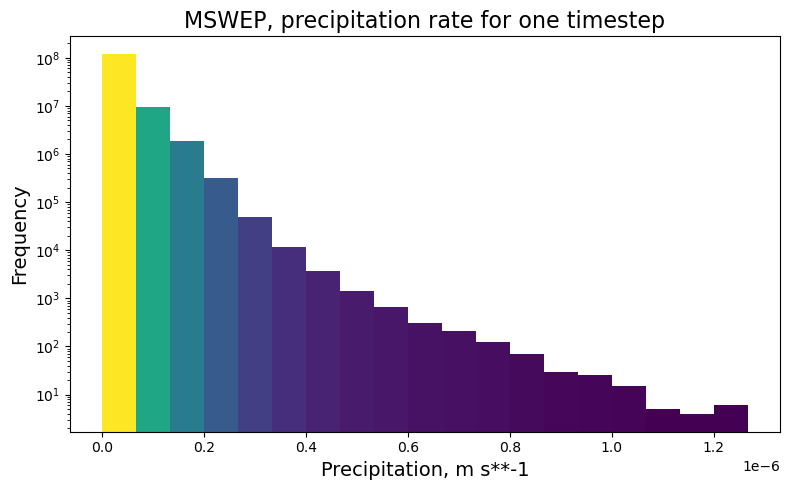

In [31]:
diag.hist_plot(hist_MSWEP, pdf = False, smooth = False, label='MSWEP/MSWEP', plot_title = "MSWEP, precipitation rate for one timestep")

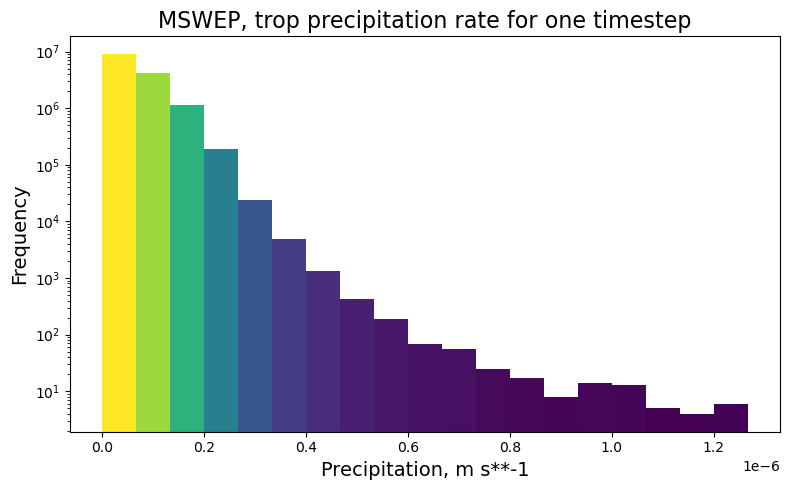

In [32]:
diag.hist_plot(hist_MSWEP_trop, pdf = False, smooth = False, label='MSWEP/MSWEP_trop', plot_title = "MSWEP, trop precipitation rate for one timestep")

#### Or we can create a pdf histogram by setting `pdf = True` in `hist_plot` function. (Default value of `pdf` is `True`)

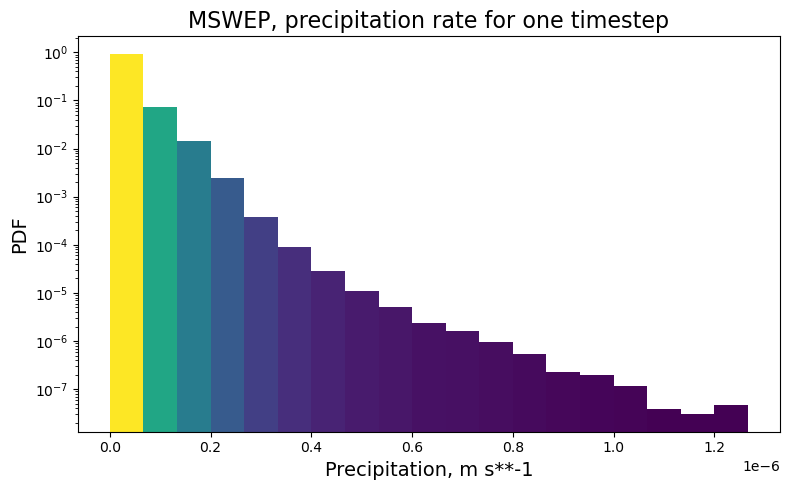

In [33]:
diag.hist_plot(hist_MSWEP, smooth = False, label='MSWEP/MSWEP', plot_title = "MSWEP, precipitation rate for one timestep")

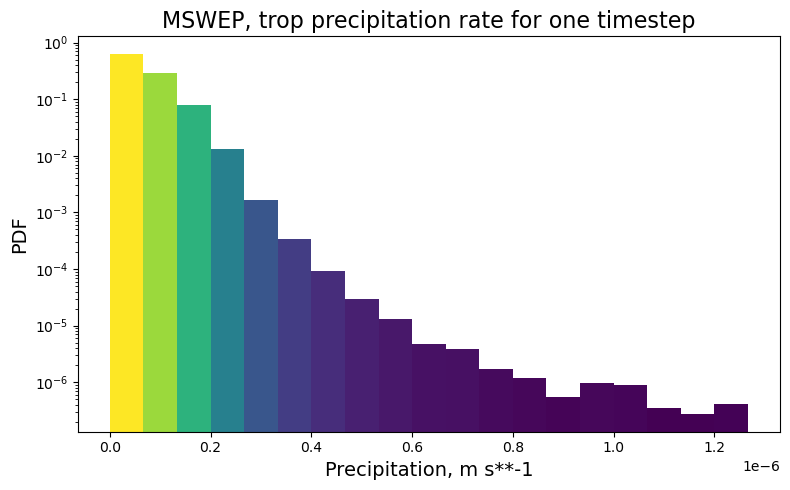

In [34]:
diag.hist_plot(hist_MSWEP_trop, pdf = True, smooth = False, label='MSWEP/MSWEP_trop', plot_title = "MSWEP, trop precipitation rate for one timestep")

#### We can also plot typical 2D dependence of counts versus the right edge of the bins by setting the `smooth = True.` It is also a default value.

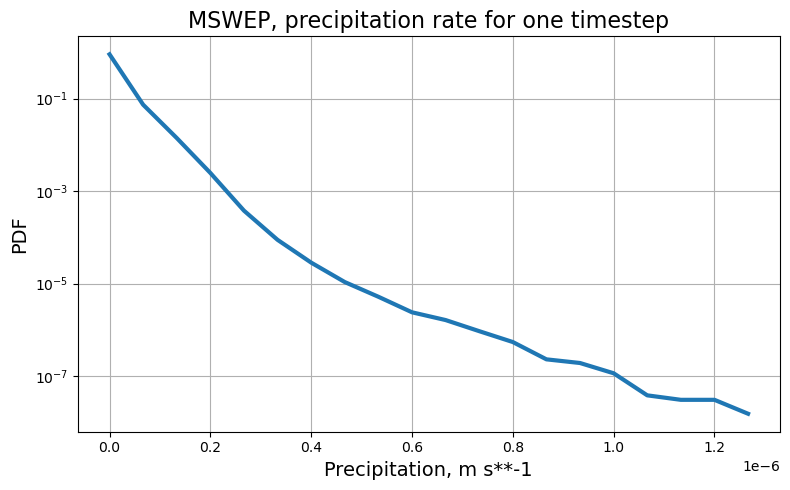

In [35]:
diag.hist_plot(hist_MSWEP, label='MSWEP/MSWEP', plot_title = "MSWEP, precipitation rate for one timestep")

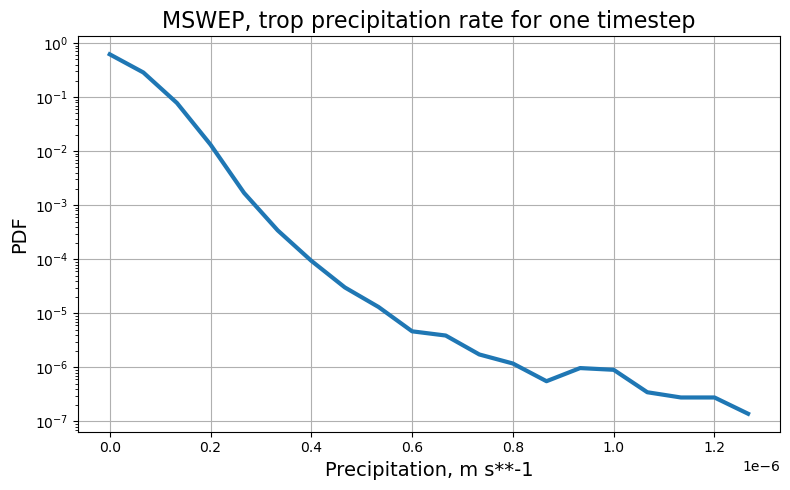

In [36]:
diag.hist_plot(hist_MSWEP_trop, pdf = True, smooth = True, label='MSWEP/MSWEP_trop', plot_title = "MSWEP, trop precipitation rate for one timestep")

### Histogram of logspaced binning. Argument `xlogscale=True` setting x-axe to the log scale. By default `xlogscale=False` 

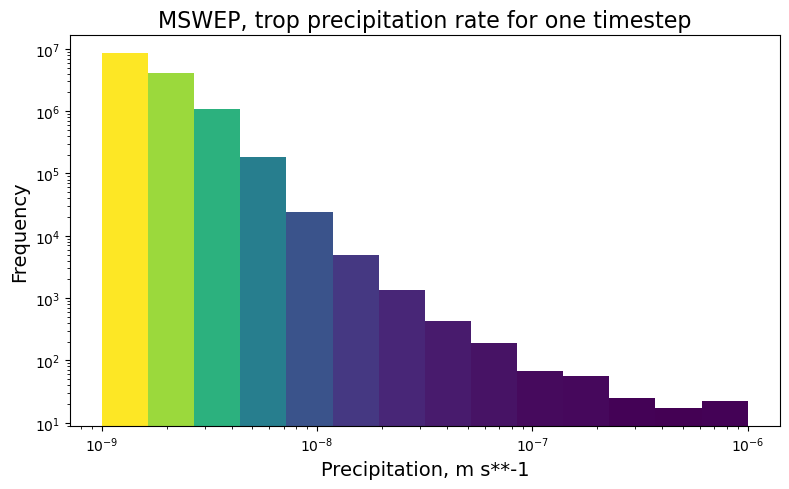

In [37]:
diag.hist_plot(hist_MSWEP_trop_logspaced, pdf = False, smooth = False, xlogscale=True, label='MSWEP/MSWEP_trop_log', plot_title = "MSWEP, trop precipitation rate for one timestep")

#### OR

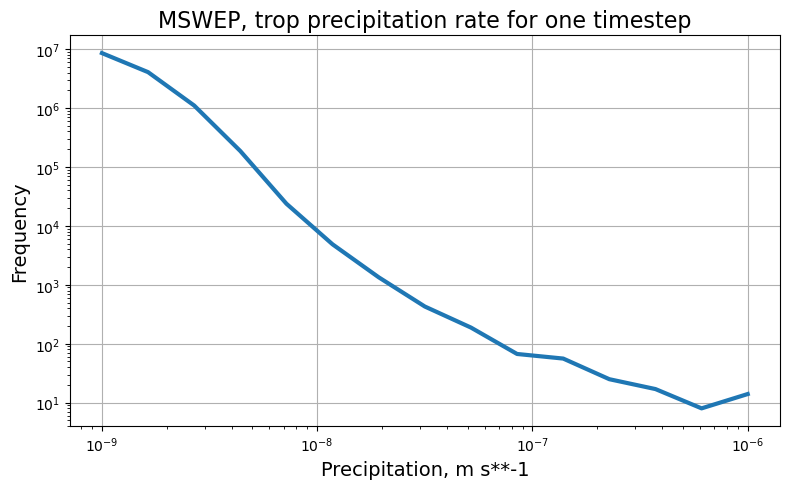

In [38]:
diag.hist_plot(hist_MSWEP_trop_logspaced, pdf = False, smooth = True, xlogscale=True, label='MSWEP/MSWEP_trop_log', plot_title = "MSWEP, trop precipitation rate for one timestep")

#### Plot of mean and median value of precipitation rate

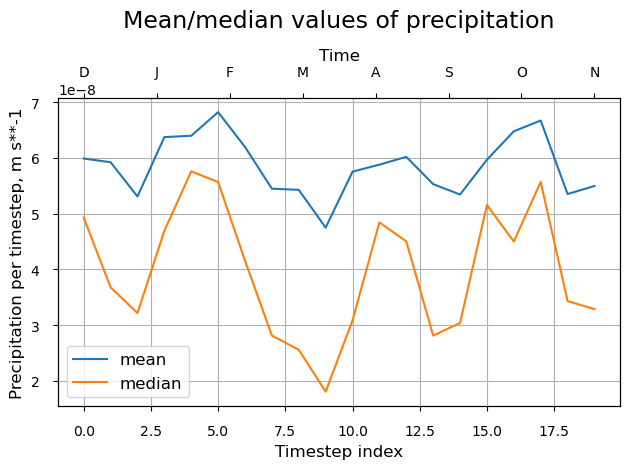

In [39]:
diag.mean_and_median_plot(MSWEP_chunk, savelabel = 'MSWEP/MSWEP')

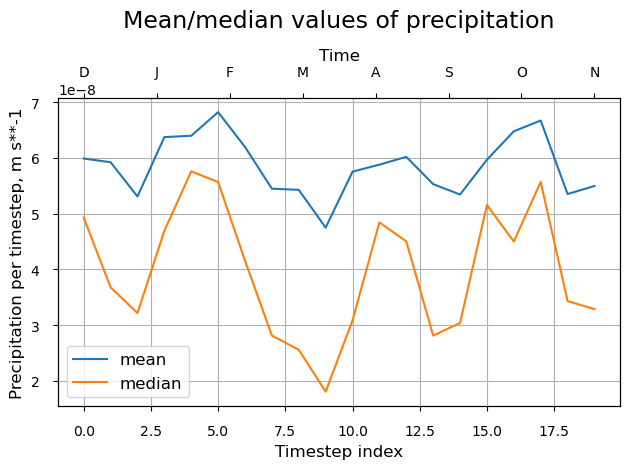

In [40]:
diag.mean_and_median_plot(MSWEP_chunk_trop, savelabel = 'MSWEP/MSWEP_trop')

#### Parameter plots

In [224]:
MSWEP_chunk = MSWEP_chunk.compute()

Done!


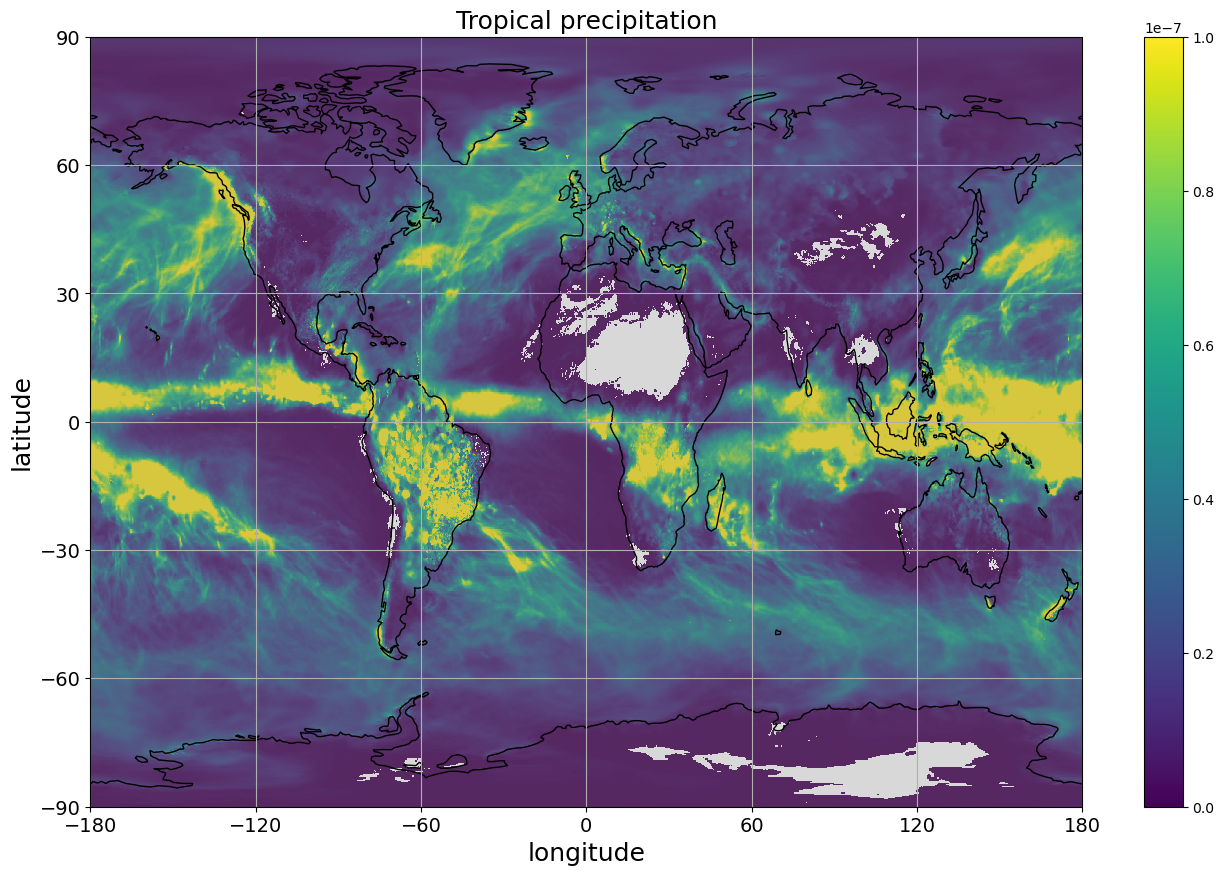

In [41]:
image_creator(MSWEP_chunk, vmin =0, vmax = 10**(-7),   figsize =2, trop_lat = 90,  label='MSWEP/MSWEP')

In [227]:
MSWEP_chunk_trop = MSWEP_chunk_trop.compute()

Done!


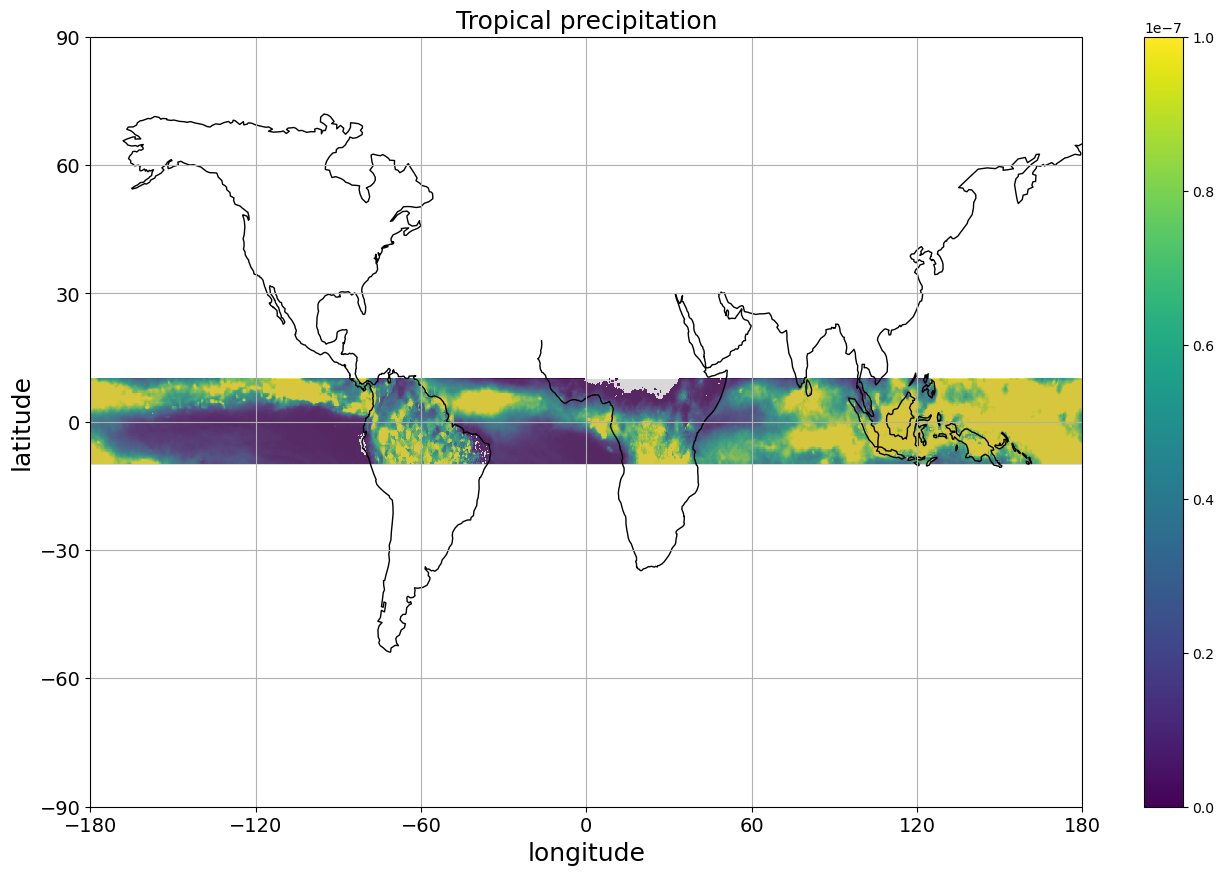

In [42]:
image_creator(MSWEP_chunk_trop, vmin =0, vmax = 10**(-7),  figsize =2, label='MSWEP/MSWEP_trop')

#

### 6.2. Animation

In [43]:
squeue_user()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4779179   compute dask-wor  b382267  R       5:48      1 l20677


0

In [ ]:
#MSWEP_chunk = reader.regrid(MSWEP["tprate"][10:30,:])
#MSWEP_chunk = MSWEP_chunk.compute()

.....................Done!


True

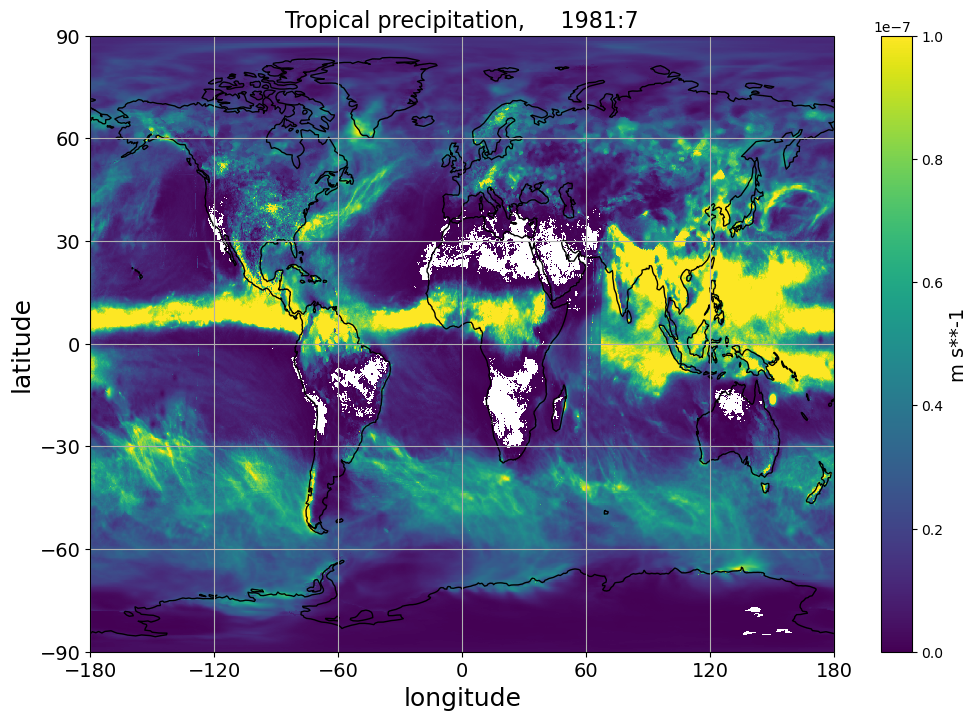

In [36]:
animation_creator(MSWEP_chunk, vmin =0, vmax = 10**(-7),   nSeconds = 20,  trop_lat = 90,  label='MSWEP_tprate')

In [20]:
MSWEP_chunk_trop = diag.ds_per_lat_range(MSWEP_chunk)
MSWEP_chunk_trop = MSWEP_chunk_trop.compute()

.....................Done!


True

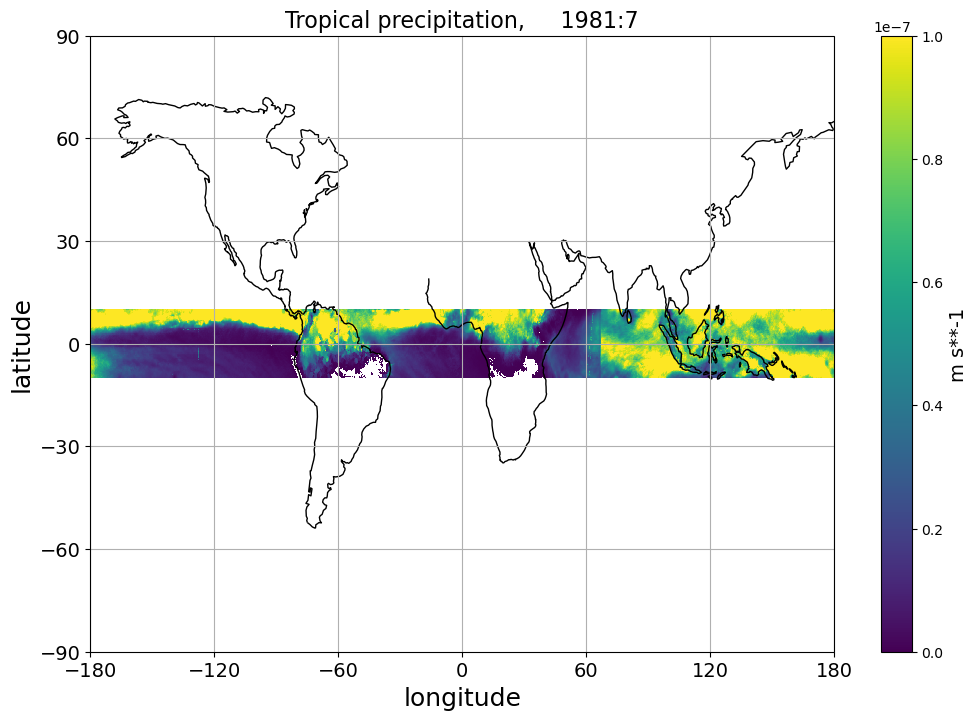

In [37]:
animation_creator(MSWEP_chunk_trop, vmin =0, vmax = 10**(-7), nSeconds = 20,  trop_lat = 10,  label='MSWEP_tprate_trop')

[Back to the top of file](#structure)

#

## 6.3 Images with the regrided the coordinates (high and low resolution)

### 6.3.1.Time regriding

In [ ]:
MSWEP_chunk_trop

In [ ]:
time_regrider(MSWEP_chunk_trop, timestep = -3)

In [ ]:
time_regrider(MSWEP_chunk_trop, new_time_unit='2H')

In [17]:
MSWEP_chunk = MSWEP_chunk.compute()

### 6.3.2 Space regriding

#### Data regriding into high resolution

In [28]:
lat_high_res    = lon_lat_regrider(MSWEP_chunk, step = 2, coord_name = 'lat')
latlon_high_res  = lon_lat_regrider(lat_high_res, step = 2, coord_name='lon')

#### Data regriding into low resolution

In [29]:
lat_low_res    = lon_lat_regrider(MSWEP_chunk, step = -10, coord_name = 'lat')
latlon_low_res  = lon_lat_regrider(lat_low_res, step = -10, coord_name='lon')

#### Original resolution

Done!


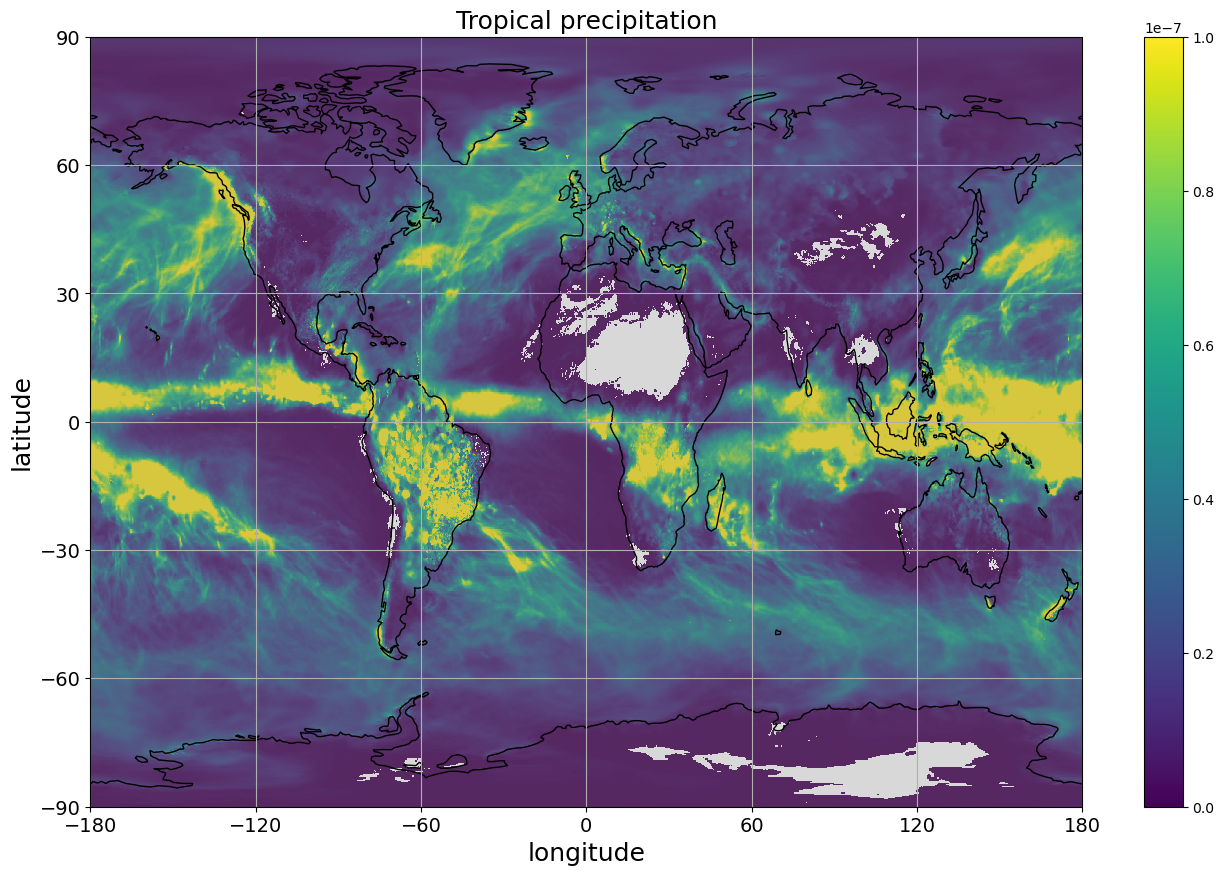

In [30]:
image_creator(MSWEP_chunk, vmin = 0, vmax = 10**(-7), figsize=2,  trop_lat = 90,  label='MSWEP/MSWEP_original')

#### High resolution

Done!


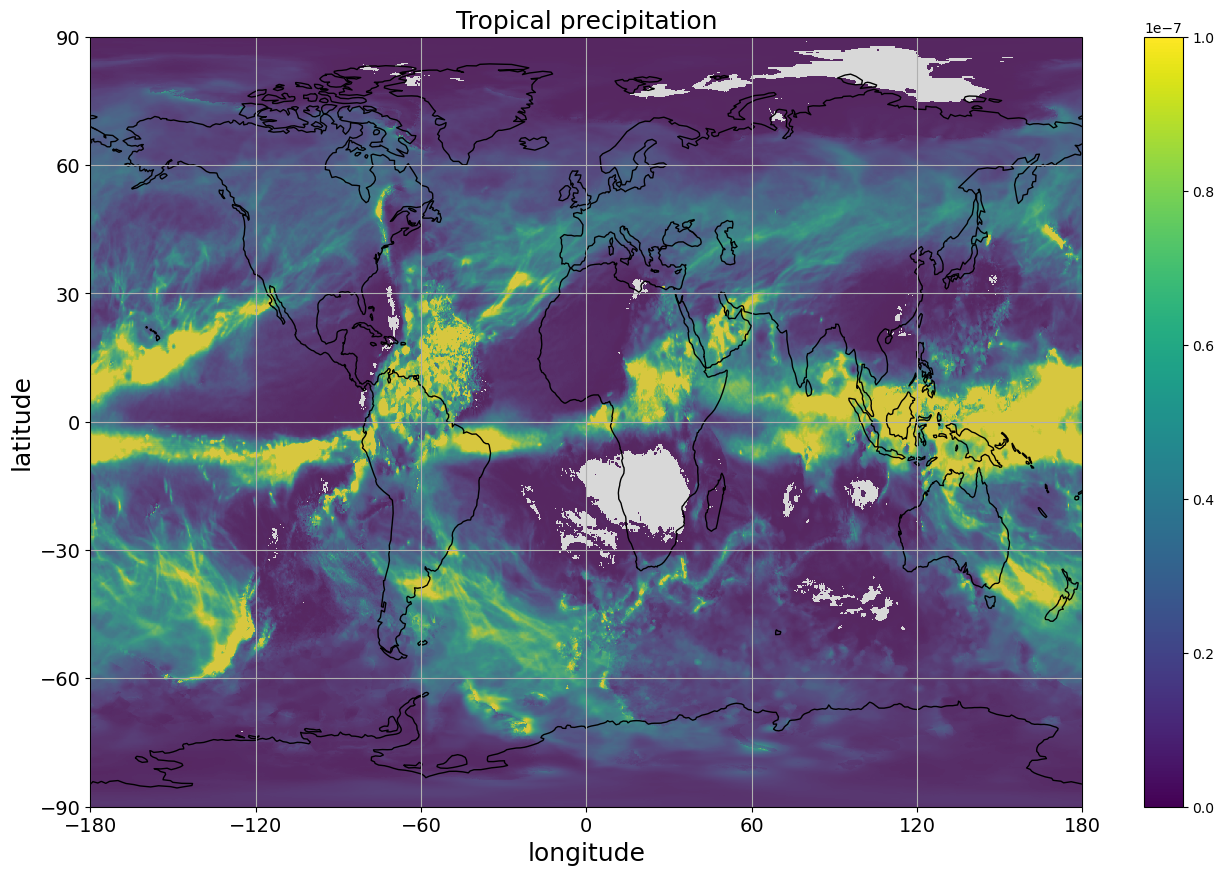

In [31]:
image_creator(latlon_high_res, vmin = 0, vmax = 10**(-7), figsize=2, trop_lat = 90,  label='MSWEP/MSWEP_regrided_highres') #

#### Low resolution

Done!


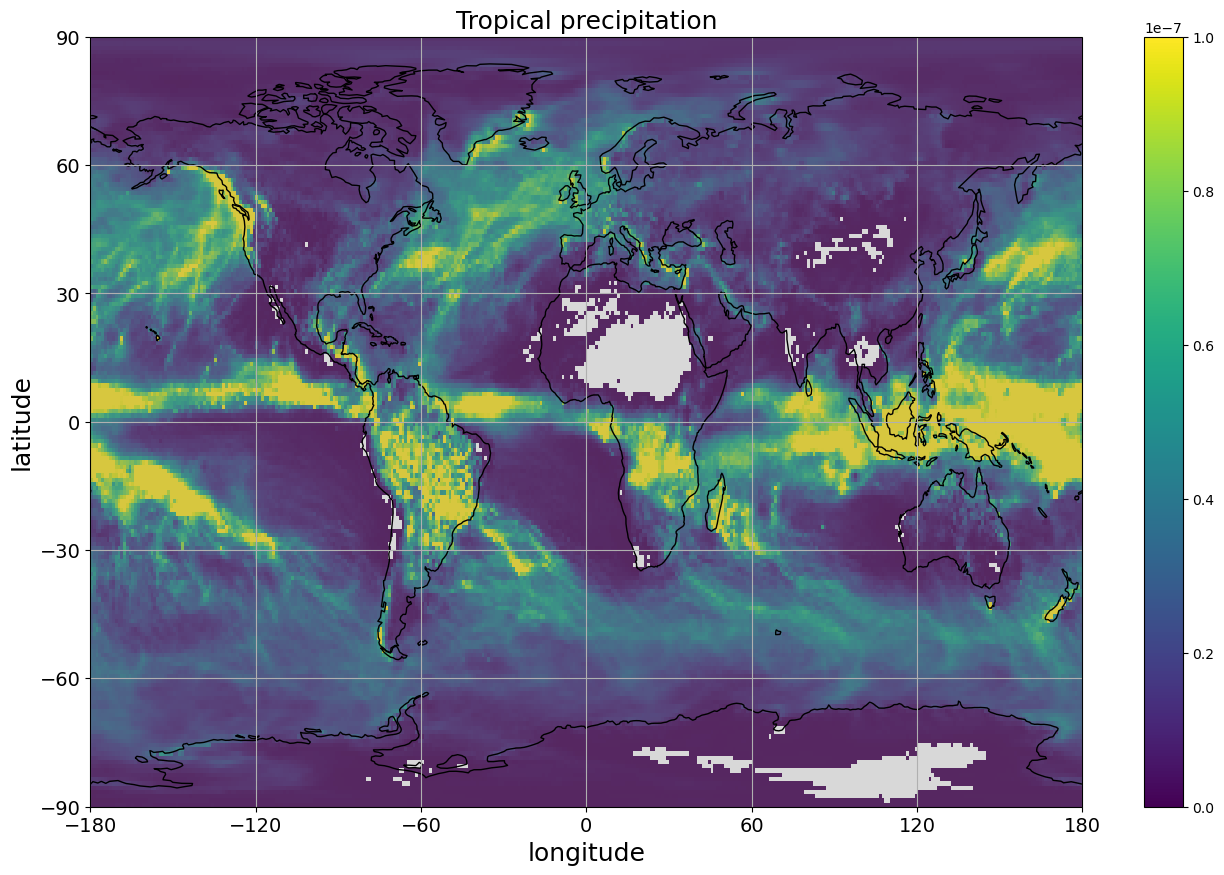

In [33]:
image_creator(latlon_low_res, vmin = 0, vmax = 10**(-7),   figsize=2, trop_lat = 90,  label='MSWEP/MSWEP_regrided_lowres') #

##### The end